<a href="https://colab.research.google.com/github/sagar9926/MTech_Atificial_Intelligence/blob/main/ML1/Fractal3_Assignment/ML_Fractal3_AssignmentProblem_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset , DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
class GurmukhiDataset(Dataset):

  def __init__(self,transform=None , train_data = False , val_data = False):
    self.transform = transform
    if train_data :
      self.data_path = "/content/gdrive/MyDrive/Gurmukhi/GurNum/train/"
    elif val_data :
      self.data_path = "/content/gdrive/MyDrive/Gurmukhi/GurNum/val/"

    image_file_list = glob.glob(self.data_path + "*")
    self.data = []

    for path in image_file_list:
      class_name = int(path.split("/")[-1])
      for image_path in glob.glob(path + "/*.*"):
        self.data.append([image_path, class_name])
        self.img_dim = (32, 32)

  def __len__(self):
    return(len(self.data))

  def __getitem__(self,idx):
    img_path, class_name = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img, self.img_dim)
    if self.transform:
      img_tensor = self.transform(img)
    #img_tensor = torch.from_numpy(img)
    #print(img_tensor.shape)
    #Torch convolutions require images to be in a channel first format; 
    #i.e for example a 3 channel image(Red, Green and Blue channels) would be generally represented as: 
    #(Width, Height, Channels) in numpy, however torch requires us to convert this to: (Channels, Width, Height).
    # For this conversion we use the permute function of torch, that allows us to change the ordering of the dimensions of a torch tensor.

    #img_tensor = img_tensor.permute(2, 0, 1)
    class_name = torch.tensor([class_name],dtype = torch.long)
    return img_tensor.float(), class_name



In [5]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation((-4.0, 4.0)),
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [6]:
train_dataset = GurmukhiDataset(transform = transform_train,train_data = True)
val_dataset = GurmukhiDataset(transform = transform_test,val_data = True)
trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize = (10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # this gives us one instance of four images and their corresponding labels

torchvision.utils.make_grid(images).shape 
# This represents the stacked images of the batch with 2 pixel padding (32* 4 + 2*5(black borders) = 138)

torch.Size([3, 36, 138])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


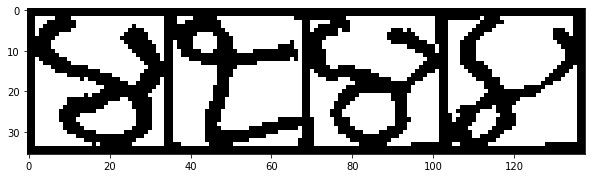

True Classes :  tensor([4]) tensor([8]) tensor([4]) tensor([4])


In [9]:
imshow(torchvision.utils.make_grid(images)) #To plot the entire batch, stacks up the images in form of long image in which individual image will apper in cells
print("True Classes : ",' '.join(str(labels[j]) for j in range(4)))

In [10]:
train_dataset = GurmukhiDataset(transform = transform_train,train_data = True)
val_dataset = GurmukhiDataset(transform = transform_test,val_data = True)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 32 , 32]

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 30 , 30]

        # pooling layer
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = [N , 48 , 15 , 15]

        self.convblock3 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 15 , 15]

        self.convblock4 = nn.Sequential(
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 13 , 13]

        # pooling layer
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = [N , 96 , 6 , 6]

        self.convblock5 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU()
        ) # output_size = [N , 192 , 6 , 6]

        # self.convblock6 = nn.Sequential(
        #     nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.BatchNorm2d(192),
        #     nn.ReLU(),
        #     nn.Dropout(0.35)
        # ) # output_size = [N , 192 , 4 , 4]

        self.fc_model = nn.Sequential(
            nn.Linear(6912 + 3072,512),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(512,256),          # (N, 120) -> (N, 84)
            nn.Linear(256,10)            # (N, 84)  -> (N, 10)
        )
      

    def forward(self, x):
        img = copy.deepcopy(x)
               
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)

        x = self.convblock5(x)
        #x = self.convblock6(x)
        x = x.view(x.size(0), -1) # (N, 16, 5, 5) -> (N, 400)
        x = torch.cat((x,img.reshape(x.size(0),-1)),dim = 1)
        
        x = self.fc_model(x)

        return F.log_softmax(x, dim=-1)


In [24]:
net = Net().to(device)
loss_fn = nn.CrossEntropyLoss() #this takes into consideration that we have to differentiate through softmax layer, given softmax is not applied in our vgg
opt = optim.SGD(net.parameters(), lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(trainloader)*5, gamma=0.1)


In [25]:
from torchsummary import summary

#vgg = models.vgg16()
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              ReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 30, 30]          20,736
       BatchNorm2d-5           [-1, 48, 30, 30]              96
              ReLU-6           [-1, 48, 30, 30]               0
         MaxPool2d-7           [-1, 48, 15, 15]               0
           Dropout-8           [-1, 48, 15, 15]               0
            Conv2d-9           [-1, 96, 15, 15]          41,472
      BatchNorm2d-10           [-1, 96, 15, 15]             192
             ReLU-11           [-1, 96, 15, 15]               0
           Conv2d-12           [-1, 96, 13, 13]          82,944
      BatchNorm2d-13           [-1, 96, 13, 13]             192
             ReLU-14           [-1, 96,

In [26]:
def evaluation(dataloader,model): 
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels.squeeze()).sum().item()
  return 100 * correct / total

In [27]:
loss_epoch_arr = []
max_epochs = 25
batch_size = 32
min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels.squeeze())
        loss.backward()
        opt.step()
        #scheduler.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(net.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(valloader, net), 
        evaluation(trainloader, net)))

Min loss 2.31
Iteration: 0/1563, Loss: 2.31
Min loss 2.25
Min loss 2.18
Min loss 2.05
Min loss 2.00
Min loss 1.85
Min loss 1.82
Min loss 1.50
Min loss 1.28
Min loss 1.05
Min loss 0.84
Epoch: 0/25, Test acc: 52.81, Train acc: 60.40
Iteration: 0/1563, Loss: 1.05
Min loss 0.56
Min loss 0.42
Min loss 0.36
Min loss 0.32
Min loss 0.27
Min loss 0.24
Min loss 0.21
Min loss 0.15
Epoch: 1/25, Test acc: 92.70, Train acc: 95.30
Iteration: 0/1563, Loss: 0.19
Min loss 0.14
Min loss 0.13
Min loss 0.10
Min loss 0.08
Epoch: 2/25, Test acc: 93.26, Train acc: 97.10
Min loss 0.07
Iteration: 0/1563, Loss: 0.07
Min loss 0.06
Min loss 0.06
Min loss 0.05
Min loss 0.02
Epoch: 3/25, Test acc: 93.26, Train acc: 96.80
Iteration: 0/1563, Loss: 0.03
Min loss 0.01
Epoch: 4/25, Test acc: 87.08, Train acc: 94.30
Iteration: 0/1563, Loss: 0.14
Epoch: 5/25, Test acc: 94.94, Train acc: 99.30
Iteration: 0/1563, Loss: 0.06
Min loss 0.01
Epoch: 6/25, Test acc: 96.63, Train acc: 99.10
Iteration: 0/1563, Loss: 0.07
Min loss 0.

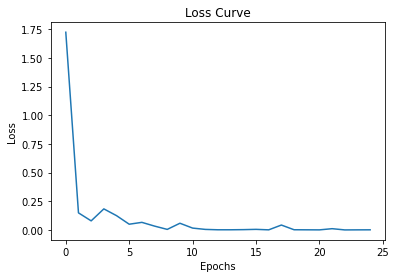

In [29]:
plt.plot(loss_epoch_arr)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.show()